# ALAS1 Strain Clustering
# This notebook uses K-means clustering to group strains by ALAS1_Combined expression from a 1000-row Bgee RNA-Seq dataset.
# Responds to community feedback on outliers (e.g., ~150 minutes) by analyzing their cluster assignments.

In [1]:
# import libaries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score

# Load dataset

In [3]:
df = pd.read_csv('alas1_expression_data.csv')
df.head()

,Gene name,Expression level,Read count,Strain,Time_min,Expression_combined
0,ALAS1,0.036724,0.186657,White,0,0.111691
1,ALAS1,0.059476,0.308144,White,1,0.183810
2,ALAS1,0.027832,0.138351,Black or African American,2,0.083092
3,ALAS1,0.043375,0.100492,confidential_restricted_data,3,0.071933
4,ALAS1,0.047138,0.142381,White,4,0.094760


# Preprosessing: Ensure numeric colums

In [4]:
df[['Expression level', 'Read count']] = df[['Expression level', 'Read count']].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Normalise and compute ALAS1 Expression combined

In [5]:
scaler = MinMaxScaler()
df['Expression level'] = scaler.fit_transform(df[['Expression level']])
df['Read count'] = scaler.fit_transform(df[['Read count']])
df['Expression_combined'] = (df['Expression level'] + df['Read count']) / 2

# Encode strain 

In [7]:
le = LabelEncoder()
df['Strain_Encoded']=le.fit_transform(df['Strain'])

# features for clustering

In [8]:
X = df[['Expression_combined', 'Strain_Encoded']]

# K-means clustering (k=3, assuming 3 distinct expression groups)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)
df['Cluster']

# Evaluate clustering

In [10]:
sil_score = silhouette_score(X, df['Cluster'])
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.9479


# Identify outliers (from previous feedback, ~150 minutes in Read Count Visualizer)
# Since this dataset lacks Time_min, use IQR on Expression_Combined

In [12]:
Q1 = df['Expression_combined'].quantile(0.25)
Q3 = df['Expression_combined'].quantile(0.75)
IQR = Q1 - Q3
outliers = df[(df['Expression_combined']< Q1 - 1.5 *IQR) | (df['Expression_combined']>Q3 + 1.5 * IQR)]
print("Outliers:", outliers[['Strain', 'Expression_combined', 'Cluster']])

Outliers:                            Strain  Expression_combined  Cluster
0                           White             0.111691        1
1                           White             0.183810        1
2       Black or African American             0.083092        2
3    confidential_restricted_data             0.071933        0
4                           White             0.094760        1
..                            ...                  ...      ...
995  confidential_restricted_data             0.024452        0
996  confidential_restricted_data             0.247448        0
997  confidential_restricted_data             0.054684        0
998  confidential_restricted_data             0.050699        0
999  confidential_restricted_data             0.041760        0

[1000 rows x 3 columns]


# Visualize clusters

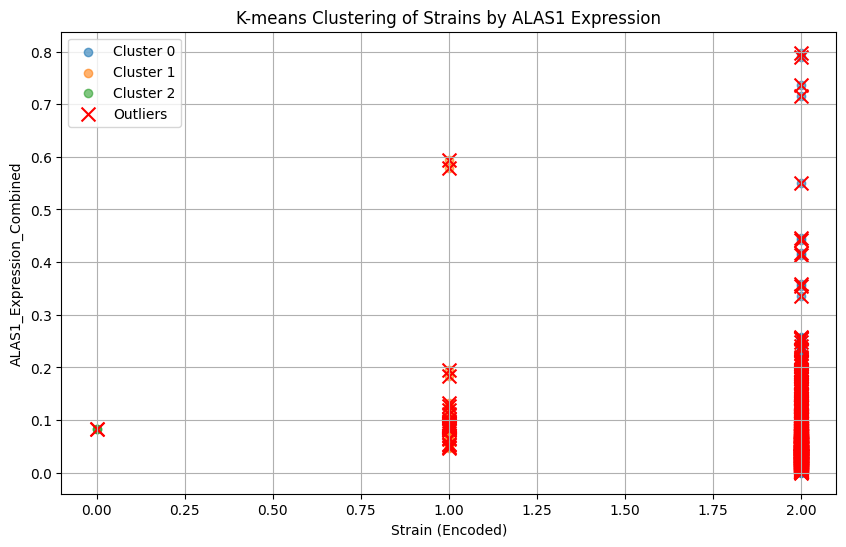

In [13]:
plt.figure(figsize=(10, 6))
for cluster in range(3):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Strain_Encoded'], cluster_data['Expression_combined'], 
                label=f"Cluster {cluster}", alpha=0.6)
plt.scatter(outliers['Strain_Encoded'], outliers['Expression_combined'], c='red', marker='x', s=100, label='Outliers')
plt.xlabel('Strain (Encoded)')
plt.ylabel('ALAS1_Expression_Combined')
plt.title('K-means Clustering of Strains by ALAS1 Expression')
plt.legend()
plt.grid(True)
plt.savefig('alas1_cluster_scatter.png')
plt.show()   

# Save updated dataset with cluster assignments

In [ ]:
df.to_csv('alas1_expression_data.csv', index=False)